In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Model Dicts

In [3]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_esm_picontrol_dict
model_run_1pct1000gtc_dict = utils.model_run_1pct_1000gtc_dict

#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

pictrl_model_weights = utils.pictrl_model_weights



## Green's Function

In [4]:
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

## Convolution

In [5]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

conv_hist_mod_mean_ds = xr.open_dataset('Outputs/hist_co2_only_conv_ds.nc4')['__xarray_dataarray_variable__']


## CMIP6 1pct

In [6]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')
ds_dif = ds_dif.where(ds_dif.model.isin(model_weights.model.values), drop = True)

ds_hist_dif = xr.open_dataset('Outputs/hist_co2_only_ds_dif.nc4')

## Emissions profile

In [7]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


## PiCtrl

In [8]:
ds_pictrl = xr.open_dataset('Outputs/ds_pictrl.nc4')

## RTCRE

In [9]:
RTCRE = xr.open_dataset('Outputs/RTCRE.nc')

# Settings

In [10]:
type_color = utils.type_color
model_color = utils.model_color

In [11]:
A = utils.A
ds_out = utils.ds_out

In [12]:
proper_names = utils.proper_names

/net/fs11/d0/emfreese/CO2_GF/utils.py:368: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


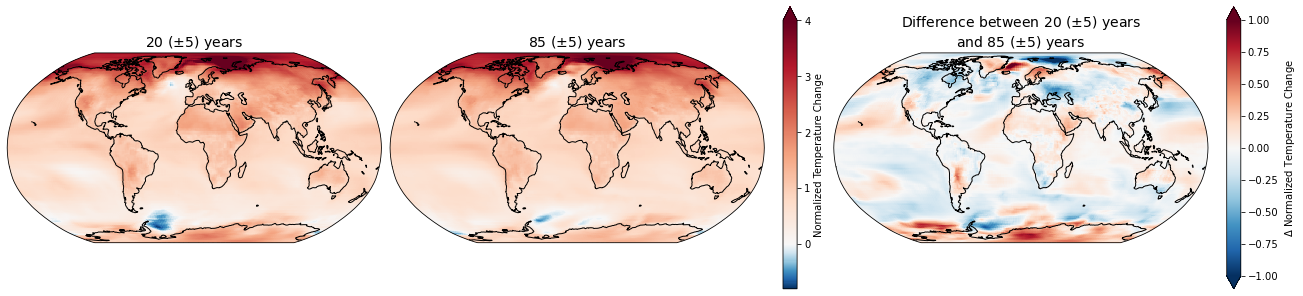

In [15]:
cmap = mpl.cm.RdBu_r
vmin = -0.8
vmax = 4
yr_dif = 5
cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - vmax / (vmax + abs(vmin)), stop=1, name='shiftedcmap')

fig, ((ax1, ax2, ax3))= plt.subplots(1,3, figsize = [18,4], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)

norm_pattern = {}
##########1pct exp##################
##contours of convolution-1pct difference
for t, ax in zip([20,85],[ax1,ax2]):

    if ax == ax1:
        add_cbar = False
        cbar_args = None
    elif ax == ax2:
        add_cbar = True
        cbar_args = {'label':'Normalized Temperature Change'}
    mean_temp = (conv_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct').weighted(A).mean()
    norm_pattern[t] = ((conv_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct')/mean_temp)
    axp1 = norm_pattern[t].plot(ax = ax, 
                              cmap = cmap_shifted, vmin = vmin, vmax = vmax,
                              add_colorbar = add_cbar,  cbar_kwargs = cbar_args,   
                              transform = ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{t} ($\pm 5$) years', fontsize = 14)


ax2.set_title('85 ($\pm 5$) years', fontsize = 14)


cmap = mpl.cm.RdBu_r
vmin = -1
vmax = 1
cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - vmax / (vmax + abs(vmin)), stop=1, name='shiftedcmap')

##########Dif convolution and CMIP6 exp##################
#contours of convolution-1pct difference
for t, ax in zip([20],[ax3]):

    axp3 = (norm_pattern[20] - norm_pattern[85]).plot(ax = ax, 
                                              cmap = cmap_shifted, 
                                              add_colorbar = True,  vmin = vmin, vmax = vmax, cbar_kwargs = {'label':'$\Delta$ Normalized Temperature Change'},  
                                              transform = ccrs.PlateCarree())
    ax.set_title('Difference between 20 ($\pm 5$) years\nand 85 ($\pm 5$) years', fontsize = 14)
    ax.coastlines()
# plt.savefig('figures/paper/figure3_normalized_temp.png', bbox_inches = 'tight', dpi = 200)
# plt.savefig('figures/paper/figure3_normalized_temp.pdf', bbox_inches = 'tight', dpi = 200)

In [14]:
yr_dif = 10

In [15]:
norm_pattern = {}
for t in [5, 25, 45, 65]:
    mean_temp = (conv_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct').weighted(A).mean()
    norm_pattern[t] = ((conv_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')).sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').sel(experiment = '1pct')/mean_temp)


/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


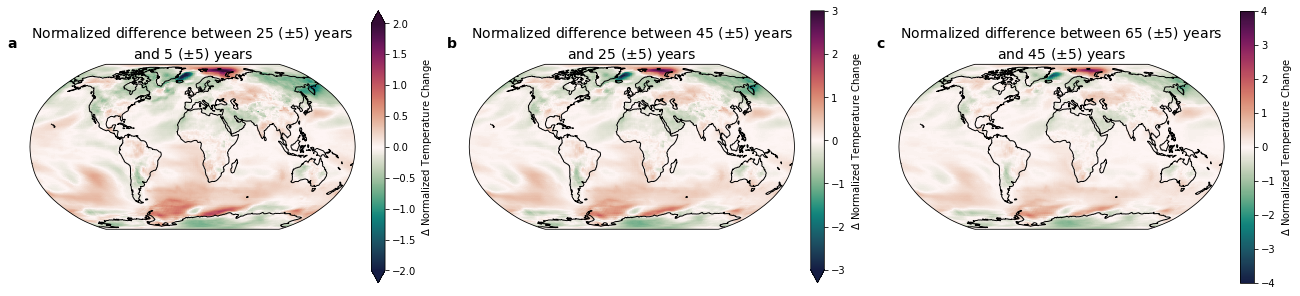

In [23]:
cmap = cmocean.cm.curl
vmin = -2
vmax = 1
yr_dif = 5

vmax_dict = {25:2, 45:3, 65: 4}
vmin_dict = {25:-2, 45:-3, 65: -4}
alpha_labels = iter(alphabet)

fig, ((ax1, ax2, ax3))= plt.subplots(1,3, figsize = [18,4], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)

#########Dif convolution and CMIP6 exp##################
#contours of convolution-1pct difference

for t, ax in zip([25, 45, 65],[ax1, ax2, ax3]):
    cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - vmax_dict[t] / (vmax_dict[t] + abs(vmin_dict[t])), stop=1, name='shiftedcmap')

    axp3 = (norm_pattern[t] - norm_pattern[5]).plot(ax = ax, 
                                              cmap = cmap_shifted, 
                                              add_colorbar = True,  vmin = vmin_dict[t], vmax = vmax_dict[t], cbar_kwargs = {'label':'$\Delta$ Normalized Temperature Change'},  
                                              transform = ccrs.PlateCarree())
    ax.set_title(f'Normalized difference between {t} ($\pm 5$) years\nand {t-20} ($\pm 5$) years', fontsize = 14)
    ax.coastlines()
    
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

#plt.savefig('figures/paper/figure3_normalized_temp.png', bbox_inches = 'tight', dpi = 200)
#plt.savefig('figures/paper/figure3_normalized_temp.pdf', bbox_inches = 'tight', dpi = 200)

/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)
/net/fs11/d0/emfreese/CO2_GF/utils.py:397: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


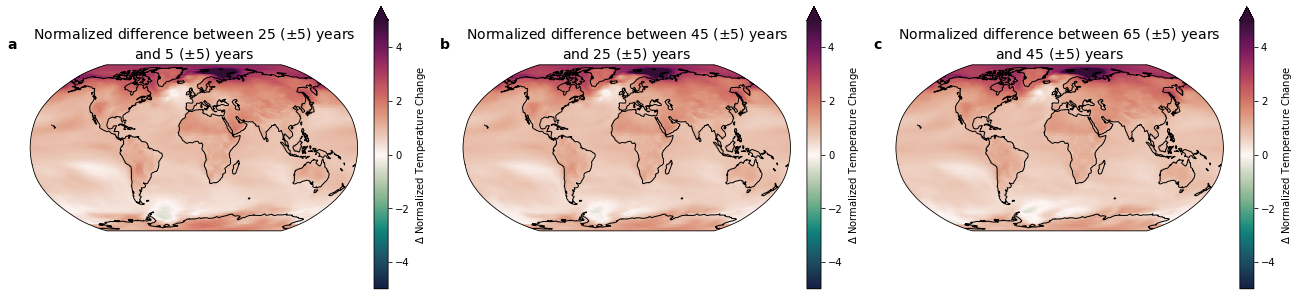

In [20]:
cmap = cmocean.cm.curl
vmin = -2
vmax = 1
yr_dif = 5

vmax_dict = {25:5, 45:5, 65: 5}
vmin_dict = {25:-5, 45:-5, 65: -5}
alpha_labels = iter(alphabet)

fig, ((ax1, ax2, ax3))= plt.subplots(1,3, figsize = [18,4], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)

#########Dif convolution and CMIP6 exp##################
#contours of convolution-1pct difference

for t, ax in zip([25, 45, 65],[ax1, ax2, ax3]):
    cmap_shifted = utils.shiftedColorMap(cmap, start=0, midpoint= 1 - vmax_dict[t] / (vmax_dict[t] + abs(vmin_dict[t])), stop=1, name='shiftedcmap')

    axp3 = (norm_pattern[t]).plot(ax = ax, 
                                              cmap = cmap_shifted, 
                                              add_colorbar = True,  vmin = vmin_dict[t], vmax = vmax_dict[t], cbar_kwargs = {'label':'$\Delta$ Normalized Temperature Change'},  
                                              transform = ccrs.PlateCarree())
    ax.set_title(f'Normalized difference between {t} ($\pm 5$) years\nand {t-20} ($\pm 5$) years', fontsize = 14)
    ax.coastlines()
    
    label = next(alpha_labels)
    ax.text(x = -0.07, y =1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

#plt.savefig('figures/paper/figure3_normalized_temp.png', bbox_inches = 'tight', dpi = 200)
#plt.savefig('figures/paper/figure3_normalized_temp.pdf', bbox_inches = 'tight', dpi = 200)